In [96]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [97]:
from socialbehavior.models.hmm import HMM
from socialbehavior.observations.ar_gaussian_observation import ARGaussianObservation
from socialbehavior.transformations.linear_transformation import LinearTransformation
from socialbehavior.utils import find_permutation, random_rotation

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
import sys
import time

# Generate synthetic data

In [98]:
torch.manual_seed(0)

K = 3
D = 2
T = 100

As = [random_rotation(D) for _ in range(K)]
true_tran = LinearTransformation(K=K, d_in=D, d_out=D, As=As)
true_observation = ARGaussianObservation(K=K, D=D, M=0, transformation=true_tran)
true_model = HMM(K=K, D=D, M=0, observation=true_observation)

z, data = true_model.sample(T)

# Define a model to fit the data

In [99]:
tran = LinearTransformation(K=K, d_in=D, d_out=D)
observation = ARGaussianObservation(K=K, D=D, M=0, transformation=tran)
model = HMM(K=K, D=D, M=0, observation=observation)

# Model fitting

In [100]:
num_iters = 9000

pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.0001)

losses = []
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(data)    
    loss.backward(retain_graph=True)
    optimizer.step()
    
    loss = loss.detach().numpy()
    losses.append(loss)
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)

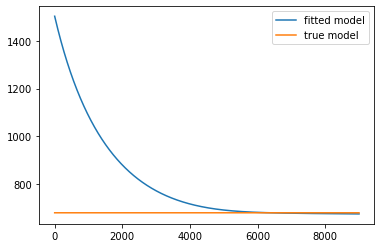

In [101]:
true_loss = true_model.loss(data)
plt.plot(losses, label='fitted model')
plt.plot(np.arange(num_iters), [true_loss]*num_iters, label='true model')
plt.legend()
plt.show()

# Now, infer the latent states

In [102]:
infer_z = model.most_likely_states(data)

perm = find_permutation(z.numpy(), infer_z, K1=K, K2=K)

model.permute(perm)
hmm_z = model.most_likely_states(data)

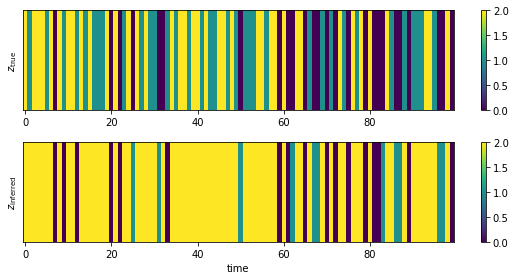

In [103]:
# Plot the true and inferred discrete states
slc = slice(0, T)

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(z[None, slc], aspect="auto")
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])
plt.colorbar()

plt.subplot(212)
plt.imshow(hmm_z[None,slc], aspect="auto")
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")
plt.colorbar()

plt.tight_layout()

# Generate sample data from the fitted model

In [117]:
sample_z, sample_data = model.sample(T)

In [118]:
sample_data.shape

torch.Size([100, 2])

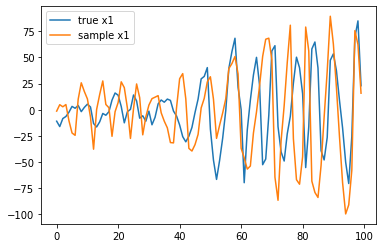

In [120]:
plt.plot(data[:,0].numpy(), label='true x1')
plt.plot(sample_data[:,0].numpy(), label='sample x1')
plt.legend()
plt.show()

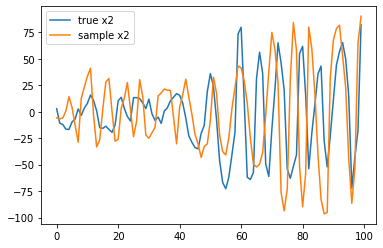

In [121]:
plt.plot(data[:,1].numpy(), label='true x2')
plt.plot(sample_data[:,1].numpy(), label='sample x2')
plt.legend()
plt.show()